# Importing Libraries

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score

# Getting only Close Prices and making a Dataset

In [38]:
folder_path = 'data/spectrogram_data'

In [39]:
start_date = "2017-01-01"
end_date = "2022-12-31"

In [40]:
stock_symbol = 'AXISBANK.NS'

In [41]:
# axis_data = yf.download(stock_symbol, start=start_date, end=end_date)

In [42]:
# axis_data.to_csv(f'{folder_path}/{stock_symbol}.csv')

In [43]:
# axis_data.head()

In [44]:
# axis_data['Close'].plot()

In [45]:
axis_data = pd.read_csv(f'{folder_path}/{stock_symbol}.csv')

In [46]:
axis_data.shape

(1484, 7)

# Working with Spectrograms

In [47]:
sample_data = axis_data['Close'].values
print(len(sample_data))

1484


In [48]:
reduced_data = sample_data[:30]

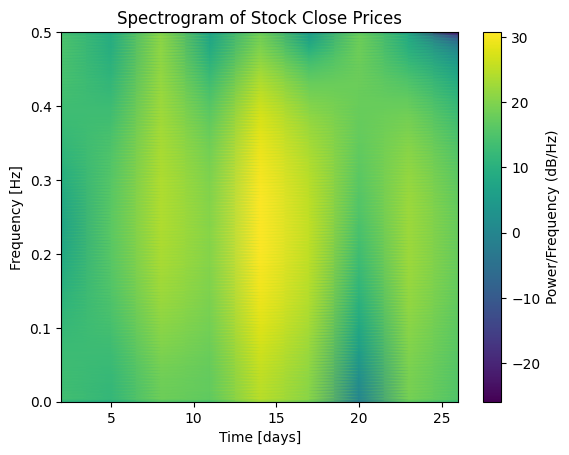

In [49]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(reduced_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=1, nfft=256, detrend='constant', scaling='density', mode='psd')

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [days]')
plt.title('Spectrogram of Stock Close Prices')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

In [50]:
print(type(Sxx))
print(Sxx.shape)
print(type(frequencies))
print(frequencies.shape)
print(type(times))
print(times.shape)

<class 'numpy.ndarray'>
(129, 9)
<class 'numpy.ndarray'>
(129,)
<class 'numpy.ndarray'>
(9,)


In [51]:
print(times)

[ 2.  5.  8. 11. 14. 17. 20. 23. 26.]


In [52]:
print(frequencies)

[0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625 0.0390625  0.04296875
 0.046875   0.05078125 0.0546875  0.05859375 0.0625     0.06640625
 0.0703125  0.07421875 0.078125   0.08203125 0.0859375  0.08984375
 0.09375    0.09765625 0.1015625  0.10546875 0.109375   0.11328125
 0.1171875  0.12109375 0.125      0.12890625 0.1328125  0.13671875
 0.140625   0.14453125 0.1484375  0.15234375 0.15625    0.16015625
 0.1640625  0.16796875 0.171875   0.17578125 0.1796875  0.18359375
 0.1875     0.19140625 0.1953125  0.19921875 0.203125   0.20703125
 0.2109375  0.21484375 0.21875    0.22265625 0.2265625  0.23046875
 0.234375   0.23828125 0.2421875  0.24609375 0.25       0.25390625
 0.2578125  0.26171875 0.265625   0.26953125 0.2734375  0.27734375
 0.28125    0.28515625 0.2890625  0.29296875 0.296875   0.30078125
 0.3046875  0.30859375 0.3125     0.31640625 0.3203125  0.32421875
 0.328125   0.33203125 0.3359375  0.33984375 0.34375    0.3476

In [53]:
print(Sxx)

[[1.11650462e+01 7.40250894e+00 3.25875320e+01 ... 5.20839691e-01
  4.14408447e+01 1.71004250e+01]
 [2.23187750e+01 1.48219551e+01 6.52757376e+01 ... 1.04951040e+00
  8.29488310e+01 3.42170939e+01]
 [2.22848520e+01 1.48727242e+01 6.55775336e+01 ... 1.07300226e+00
  8.31500736e+01 3.42657770e+01]
 ...
 [2.95384668e+01 8.41801563e+00 1.30291631e+02 ... 6.59546009e+01
  7.84073061e+00 1.11222475e-01]
 [2.95789504e+01 8.36140859e+00 1.30048366e+02 ... 6.59897913e+01
  7.57137429e+00 3.16482050e-02]
 [1.47962275e+01 4.17126250e+00 6.49836032e+01 ... 3.30007625e+01
  3.74076177e+00 2.55261742e-03]]


# Setting up the Prediction Models

In [54]:
def generate_spectrogram(window_data):
    frequencies, times, Sxx = spectrogram(reduced_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=1, nfft=256, detrend='constant', scaling='density', mode='psd')
    return frequencies, times, Sxx

1000


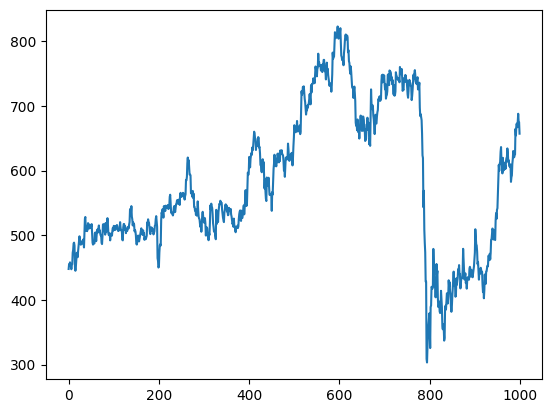

In [55]:
noofdays = 30

close_prices = axis_data['Close'].values
close_prices = close_prices[0:1000]
print(len(close_prices))

# plot the close prices
plt.plot(close_prices)

In [56]:
X = []
y = []

for i in range(len(close_prices) - noofdays):
    window_data = close_prices[i:i + noofdays]
    spectrogram_data = generate_spectrogram(window_data)
    X.append(spectrogram_data[2])
    # Label: 1 if price on day 26 is greater than day 25, else 0
    label = 1 if close_prices[i + noofdays] > close_prices[i + noofdays - 1] else 0
    y.append(label)

In [57]:
print(len(X))
print(len(y))

970
970


In [58]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(970, 129, 9)
(970,)


In [71]:
# split X and y into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

# Preprocess Function

In [72]:
def preprocess_data(X_train, X_test, num_channels=3):
    X_train = torch.tensor(X_train, dtype=torch.float32).reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    X_test = torch.tensor(X_test, dtype=torch.float32).reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

    X_train = X_train.repeat(1, num_channels, 1, 1)  
    X_test = X_test.repeat(1, num_channels, 1, 1)

    return X_train, X_test

# AlexNet

In [73]:
def doAlexnet(X_train, y_train, X_test, y_test):

    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.alexnet(weights=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')

# ResNet

In [75]:
def doresNet(X_train, y_train, X_test, y_test):

    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2) 

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')


# DenseNet

In [78]:
def doDenseNet(X_train, y_train, X_test, y_test):
    
    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.densenet121(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, 2)  

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')


# EfficientNet

In [82]:
def doEfficientNet(X_train, y_train, X_test, y_test):
    
    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')

# Testing out Performances

In [74]:
doAlexnet(X_train, y_train, X_test, y_test)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 646.0083, Training Accuracy: 54.25%
Epoch [2/10], Loss: 17.3811, Training Accuracy: 47.68%
Epoch [3/10], Loss: 17.5825, Training Accuracy: 48.32%
Epoch [4/10], Loss: 17.5598, Training Accuracy: 48.45%
Epoch [5/10], Loss: 17.3889, Training Accuracy: 50.77%
Epoch [6/10], Loss: 17.3170, Training Accuracy: 49.48%
Epoch [7/10], Loss: 17.4064, Training Accuracy: 48.45%
Epoch [8/10], Loss: 17.3287, Training Accuracy: 51.29%
Epoch [9/10], Loss: 17.3329, Training Accuracy: 48.07%
Epoch [10/10], Loss: 17.5446, Training Accuracy: 52.84%
Test Accuracy: 54.12%


In [77]:
doresNet(X_train, y_train, X_test, y_test)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Pdogg Windows10/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch [1/10], Loss: 18.0213, Training Accuracy: 49.10%
Epoch [2/10], Loss: 17.6782, Training Accuracy: 47.29%
Epoch [3/10], Loss: 17.4809, Training Accuracy: 51.68%
Epoch [4/10], Loss: 17.5110, Training Accuracy: 50.64%
Epoch [5/10], Loss: 17.6908, Training Accuracy: 50.39%
Epoch [6/10], Loss: 18.4702, Training Accuracy: 49.87%
Epoch [7/10], Loss: 17.5896, Training Accuracy: 51.93%
Epoch [8/10], Loss: 17.6114, Training Accuracy: 49.61%
Epoch [9/10], Loss: 17.8168, Training Accuracy: 50.39%
Epoch [10/10], Loss: 17.2569, Training Accuracy: 51.16%
Test Accuracy: 54.12%


In [80]:
doDenseNet(X_train, y_train, X_test, y_test)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Pdogg Windows10/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100.0%


Epoch [1/10], Loss: 18.2298, Training Accuracy: 50.13%
Epoch [2/10], Loss: 17.4991, Training Accuracy: 49.10%
Epoch [3/10], Loss: 17.8994, Training Accuracy: 49.10%
Epoch [4/10], Loss: 17.6370, Training Accuracy: 50.39%
Epoch [5/10], Loss: 18.5653, Training Accuracy: 49.36%
Epoch [6/10], Loss: 17.8271, Training Accuracy: 47.04%
Epoch [7/10], Loss: 17.6489, Training Accuracy: 50.64%
Epoch [8/10], Loss: 18.3603, Training Accuracy: 51.68%
Epoch [9/10], Loss: 17.5201, Training Accuracy: 50.90%
Epoch [10/10], Loss: 17.3769, Training Accuracy: 51.42%
Test Accuracy: 45.88%


In [83]:
doEfficientNet(X_train, y_train, X_test, y_test)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 18.2757, Training Accuracy: 47.94%
Epoch [2/10], Loss: 17.7647, Training Accuracy: 50.13%
Epoch [3/10], Loss: 17.6910, Training Accuracy: 50.52%
Epoch [4/10], Loss: 17.4698, Training Accuracy: 51.29%
Epoch [5/10], Loss: 17.6021, Training Accuracy: 50.77%
Epoch [6/10], Loss: 17.4567, Training Accuracy: 48.58%
Epoch [7/10], Loss: 17.5328, Training Accuracy: 48.84%
Epoch [8/10], Loss: 17.5780, Training Accuracy: 51.16%
Epoch [9/10], Loss: 17.4795, Training Accuracy: 49.61%
Epoch [10/10], Loss: 17.6611, Training Accuracy: 47.81%
Test Accuracy: 45.88%
